In [ ]:
import numpy as np
import pandas as pd
import requests
import json
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil.relativedelta as relativedelta
import scipy.stats as st
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# We are interested in the timeframe 2007-01-01 until 2020-01-01
from dateutil.relativedelta import *
start = datetime.datetime(2007, 1, 1)
dt_array = np.array([start + relativedelta(months=i) for i in range(13*12)]).astype("datetime64")

# Financial Data

In [ ]:
#Stock market data
stock_data = pd.read_excel('financial_data.xlsx')
print(stock_data.shape[1] - 1,'features and',stock_data.shape[0],'data points')
stock_data.head()

In [ ]:
# Take the average stock prices per day (high+low/2)
stock_data_avg = stock_data.drop(['Siste', 'Offisielt omsatt (NOK)', 'Lav', 'Høy'], axis=1)
stock_data_avg['avg stock price'] = (stock_data['Høy'] + stock_data['Lav'])/2

# Take only data from Jan 1st 2007 until Jan 1st 2020
stock_data_avg = stock_data_avg[(stock_data_avg['OSEBX']>'2007-01-01')& (stock_data_avg['OSEBX']<'2020-01-01')].rename(columns={"OSEBX": "date"})
stock_data_avg.head() 

In [ ]:
# Visualizing the stock prices
sns.set()
_ = plt.plot(stock_data_avg['date'],stock_data_avg['avg stock price'] )
_ = plt.xlabel('date')
_ = plt.ylabel('avg stock price')
_ = plt.title('Average stock price per day from 2007-2020')

In [ ]:
# Group by month
monthly_avg = stock_data_avg.groupby([stock_data_avg.date.dt.year,stock_data_avg.date.dt.month])['avg stock price'].agg(['mean','median','std'])

# Rename index cols
monthly_avg.index = monthly_avg.index.rename(['Year','Month'])


In [ ]:
stock_monthly_avg = pd.DataFrame()
stock_monthly_avg['date'] = dt_array
stock_monthly_avg['date'] = stock_monthly_avg['date'].astype('datetime64')
stock_monthly_avg['mean stock price'] = monthly_avg['mean'].values

_ = plt.plot(stock_monthly_avg['date'],stock_monthly_avg['mean stock price'] )
_ = plt.xlabel('month')
_ = plt.ylabel('mean stock price')
_ = plt.title('Mean stock price per month from 2007-2020')

# Company Register

In [ ]:
#Business data
json_file = open('enheter_alle.json')
data = json.load(json_file)
len(data)

In [ ]:
# The parameters that we are interested in
o_arr, r_arr, s_arr  = [], [], []

In [ ]:
# Generate dataset WITH missing 'founding date'
for e in data:
    if not bool(e['registrertIFrivillighetsregisteret']):
        o_arr.append(int(e['organisasjonsnummer']))
        r_arr.append(np.datetime64(e['registreringsdatoEnhetsregisteret']))
        if 'stiftelsesdato' in e:
            s_arr.append(np.datetime64(e['stiftelsesdato']))
        else:
            s_arr.append(np.datetime64('0000-01-01'))


In [ ]:
df = pd.DataFrame()
df['organisation number'] = o_arr
df['registry date'] = r_arr
df['founding date'] = s_arr

df['organisation number'] = df['organisation number'].astype('int')
df['registry date'] = df['registry date'].astype("datetime64")
df['founding date'] = pd.to_datetime(df['founding date'], yearfirst=True, errors='coerce')

In [ ]:
print("The number of companies registered is: " + str(len(df)))

In [ ]:
businesses = df[(df['founding date']>np.datetime64('2007-01-01')) & (df['founding date']<np.datetime64('2020-01-01'))]
businesses.head()

In [ ]:
print("Companies registered between Jan 1st 2007 - Jan 1st 2020 is: " + str(len(businesses)))

In [ ]:
sns.set()
businesses["founding date"] = businesses["founding date"].astype("datetime64")
busPerYear = businesses['founding date'].groupby(businesses["founding date"].dt.year).count()

In [ ]:
_ = busPerYear.plot(kind='bar')
_ = plt.xlabel('founding year')
_ = plt.ylabel('number of businesses')
_ = plt.title('Businesses distributed by founding year')
plt.show()

In [ ]:
# Founding Date for all businesses last 30 years(1990-2020)
all_buss = df[(df['founding date']>np.datetime64('1990-01-01')) & (df['founding date']<np.datetime64('2020-01-01'))].astype("datetime64")
all_buss_per_year = all_buss['founding date'].groupby(all_buss["founding date"].dt.year).count()
_ = all_buss_per_year.plot(kind='bar')
_ = plt.xlabel('founding year')
_ = plt.ylabel('number of businesses')
_ = plt.title('Businesses distributed by founding year')
plt.show()

In [ ]:
# Registry Date for all businesses last 25 years(1995-2020)
all_buss = df[(df['registry date']>np.datetime64('1995-01-01')) & (df['registry date']<np.datetime64('2020-01-01'))].astype("datetime64")
all_buss_per_year = all_buss['registry date'].groupby(all_buss["registry date"].dt.year).count()
_ = all_buss_per_year.plot(kind='bar')
_ = plt.xlabel('registry year')
_ = plt.ylabel('number of businesses')
_ = plt.title('Businesses distributed by registry year')
plt.show()

In [ ]:
busPerMonthYear = businesses['founding date'].groupby([businesses["founding date"].dt.year, businesses["founding date"].dt.month]).count()

# Rename index cols
busPerMonthYear.index = busPerMonthYear.index.rename(['Year','Month'])
busPerMonthYear.head()

In [ ]:
print(len(busPerMonthYear.values)==len(dt_array))

In [ ]:
bus_per_month = pd.DataFrame()
bus_per_month['month'] = dt_array
bus_per_month['businesses'] = busPerMonthYear.values

_ = plt.plot(bus_per_month['month'],bus_per_month['businesses'])
_ = plt.xlabel('date')
_ = plt.ylabel('number of businesses founded')
_ = plt.title('Number of businesses founded by date')


In [ ]:
# Running mean - using a sliding window with a convolution kernel 
N = 10
conv_bus = pd.DataFrame()
conv_bus['date'] = dt_array[int(N/2)-1:-int(N/2)]
conv_bus['businesses'] = np.convolve(busPerMonthYear, np.ones((N,))/N, mode='valid')

_ = plt.plot(conv_bus['date'],conv_bus['businesses'])
_ = plt.xlabel('month')
_ = plt.ylabel('number of businesses founded')
_ = plt.title('Running mean of number of businesses founded')
plt.show()

#### Explanation
The running mean is a case of the mathematical operation of convolution. For the running mean, you slide a window along the input and compute the mean of the window's contents. For discrete 1D signals, convolution is the same thing, except instead of the mean you compute an arbitrary linear combination, i.e. multiply each element by a corresponding coefficient and add up the results. Those coefficients, one for each position in the window, are sometimes called the convolution kernel. Now, the arithmetic mean of N values is *(x_1 + x_2 + ... + x_N) / N*, so the corresponding kernel is *(1/N, 1/N, ..., 1/N)*, and that's exactly what we get by using *np.ones((N,))/N*.

In [ ]:
# For compatibility reasons
business_data = conv_bus
stock_data = stock_monthly_avg[int(N/2)-1:-int(N/2)]
print(len(business_data)==len(stock_data))

# Correlation Analysis
First let's look at the two datasets we have

In [ ]:
business_data.head()

In [ ]:
stock_data.head()

In [ ]:
# Normalization

business_data['businesses'] = (business_data['businesses'] -
                               np.mean(business_data['businesses'])) / np.std(business_data['businesses'])

stock_data['mean stock price'] = (stock_data['mean stock price'] -
                                  np.mean(stock_data['mean stock price'])) / np.std(stock_data['mean stock price'])


In [ ]:
_ = plt.plot(business_data['businesses'],stock_data['mean stock price'], marker='.', linestyle='None')
_ = plt.xlabel('number of foundings (norm)')
_ = plt.ylabel('stock prices (norm)')
_ = plt.title('Correlation of num of founded companies and stock prices')

In [ ]:
r = st.pearsonr(business_data['businesses'],stock_data['mean stock price'])
print('Pearson correlation coefficient is ' + str(r))

In [ ]:
_ = plt.plot(business_data['businesses'],stock_data['mean stock price'], marker='.', linestyle='None', label='Correlation')
_ = plt.xlabel('change in numb of foundings (norm)')
_ = plt.ylabel('change stock prices (norm)')
_ = plt.title('Correlation of change rate of num of founded companies and stock prices')
_ = plt.legend()


In [ ]:
short

In [ ]:
from scipy.stats import pearsonr
x = business_data['businesses']
y = stock_data['mean stock price']
stat, p = pearsonr(x, y)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

# The rate of change

In [ ]:
business_data = conv_bus
for i in range(0, len(business_data)-1):
    business_data['businesses'][i+1]-=business_data['businesses'][i]

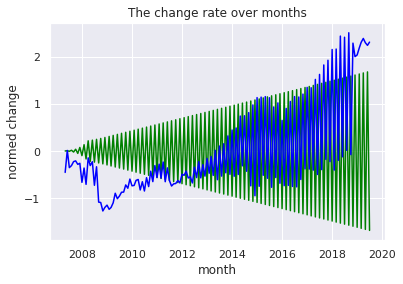

In [528]:
_ = plt.plot(business_data['date'],business_data['businesses'], label='change in stock prices', color='green')
_ = plt.plot(stock_data['date'],stock_data['mean stock price'], label='change in stock prices', color='blue')
_ = plt.xlabel('month')
_ = plt.ylabel('normed change')
_ = plt.title('The change rate over months')
plt.show()

In [ ]:
stock_data = stock_monthly_avg[int(N/2)-1:-int(N/2)]
for i in range(int(N/2)-1, len(business_data)-1-int(N/2)):
    stock_data['mean stock price'][i+1]-=stock_data['mean stock price'][i]

In [ ]:
business_data[1:]
stock_data[1:]

print(len(business_data)==len(stock_data))

In [ ]:
# Kwiatkowski-Phillips-Schmidt-Shin test
from statsmodels.tsa.stattools import kpss
stat, p, lags, crit = kpss(business_data['businesses'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably not Stationary')
else:
	print('Probably Stationary')

In [ ]:
from scipy.stats import pearsonr
x = business_data['businesses']
y = stock_data['mean stock price']
stat, p = pearsonr(x, y)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

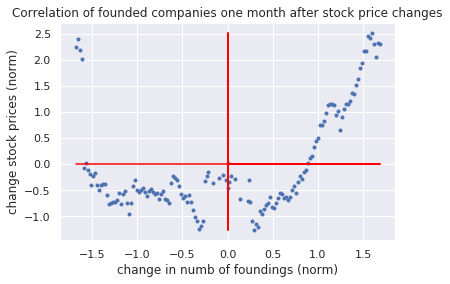

In [538]:
_ = plt.plot(business_data['businesses'][1:],stock_data['mean stock price'][:-1], marker='.', linestyle='None', label='Correlation')
_ = plt.plot(business_data['businesses'][1:],np.zeros(len(business_data['businesses'][1:])), label='0-line', color='red')
_ = plt.plot(np.zeros(len(business_data['businesses'][1:])),stock_data['mean stock price'][:-1] , label='0-line', color='red')
_ = plt.xlabel('change in numb of foundings (norm)')
_ = plt.ylabel('change stock prices (norm)')
_ = plt.title('Correlation of founded companies one month after stock price changes')
